# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Ryan Janssen:

Enrollment Status (109A, 121A, 209A, or E109A): 209a

Import libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

%matplotlib inline

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [4]:
df_train = pd.read_csv("Bikeshare_train.csv", index_col=0)
df_test = pd.read_csv("Bikeshare_test.csv", index_col=0)

frames=[df_train, df_test]
df_total = pd.concat(frames)
df_total=df_total.rename(columns={"count":"count_rides"})
df_total.head(n=10)
#print (df_total[df_total.weather==3])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count_rides
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0
5,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,69.7083,0.342667,4451.0
6,4.0,11.0,0.0,4.0,1.0,1.0,7.0,11.0,33.3478,0.347835,5315.0
7,2.0,6.0,0.0,2.0,1.0,1.0,23.0,26.0,50.7083,0.269283,4891.0
8,3.0,9.0,0.0,6.0,0.0,1.0,23.0,26.0,50.1667,0.247521,8714.0
9,3.0,8.0,0.0,3.0,1.0,1.0,30.0,30.0,61.9583,0.169771,7347.0


In [5]:
# First, let's have a quick look at the count/distribution of each variable in df:
df_total.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count_rides
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789406,0.190486,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242910,0.077498,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.022392,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.134950,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.666700,0.180975,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020850,0.233214,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.507463,10045.000000


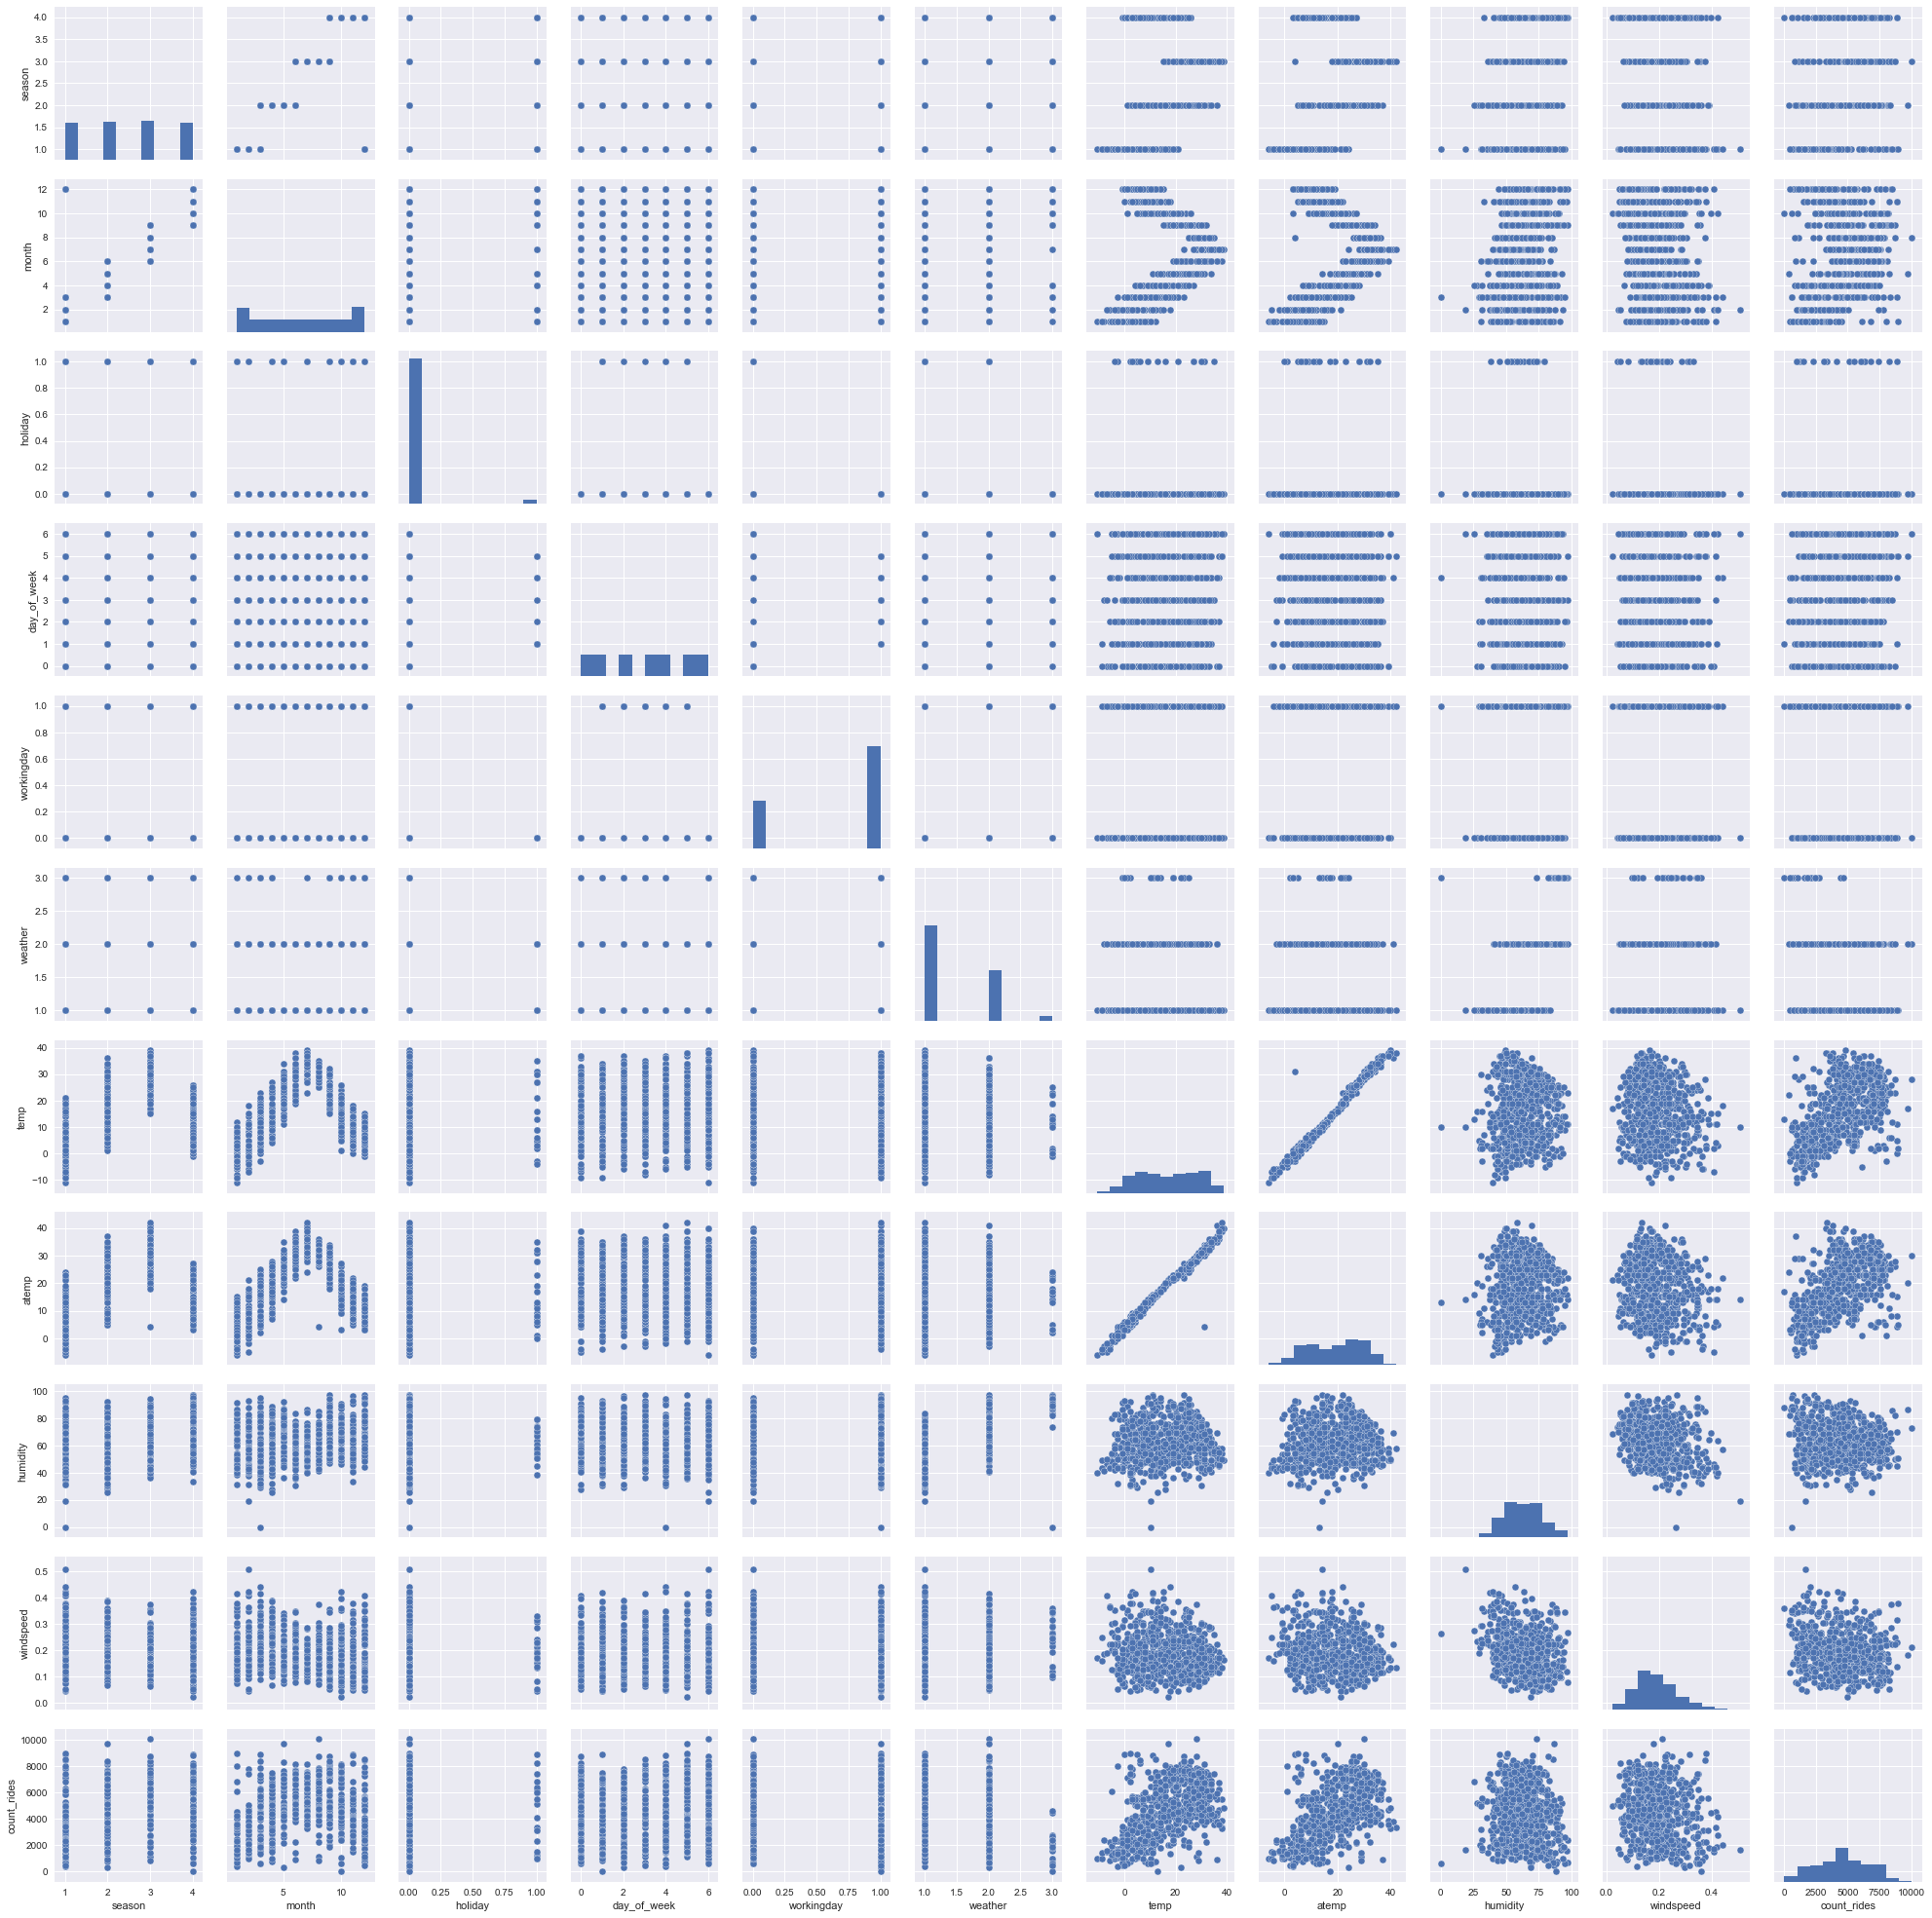

In [6]:
# And let's do a quick scan of all of the variable relationships
g = sns.pairplot(df_total)

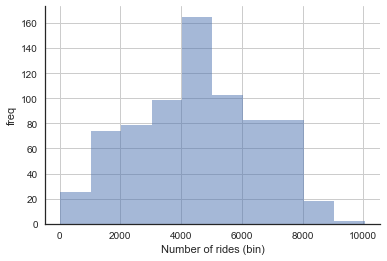

In [7]:
# Visualisation of the key data features 

with sns.axes_style("white"):
    df_total.count_rides.hist(alpha=0.5)
    plt.xlabel("Number of rides (bin)");
    plt.ylabel("freq")
    sns.despine()

1) How does the number of bike rentals vary between weekdays and weekends?

(0, 5500)

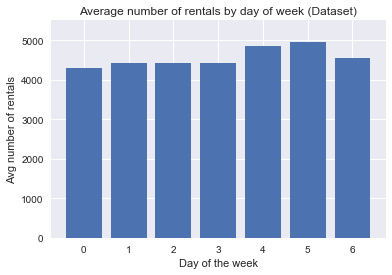

In [8]:
#Examining average number of rides per day of the week
mean_count_by_day = df_total.groupby('day_of_week').count_rides.mean()

plt.bar(mean_count_by_day.index[:],mean_count_by_day)
plt.title('Average number of rentals by day of week (Dataset)')
plt.ylabel("Avg number of rentals")
plt.xlabel("Day of the week")
plt.ylim(0,5500)

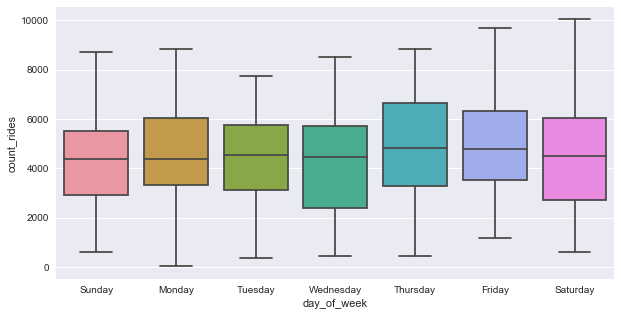

In [9]:
# Let's take a closer look with a boxplot:
x_train = df_total['day_of_week']
y_train = df_total['count_rides']

plt.figure(figsize=(10,5))
day_rental_freq = sns.boxplot(x_train, y_train)
plt.xticks([0,1,2,3,4,5,6],['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday',"Saturday"]);


In [10]:
def plot_categorical_differences(df,cat_to_split,predictor_col,response_col,hue_col):
#plots a grid of splitted category, with predictor predicting outcome of response,hue is a binary variable 
    
g = sns.FacetGrid(df, col=cat_to_split, hue=hue_col, palette="Set1")
g.map(plt.scatter, predictor_col, response_col, alpha=0.5, s=10);

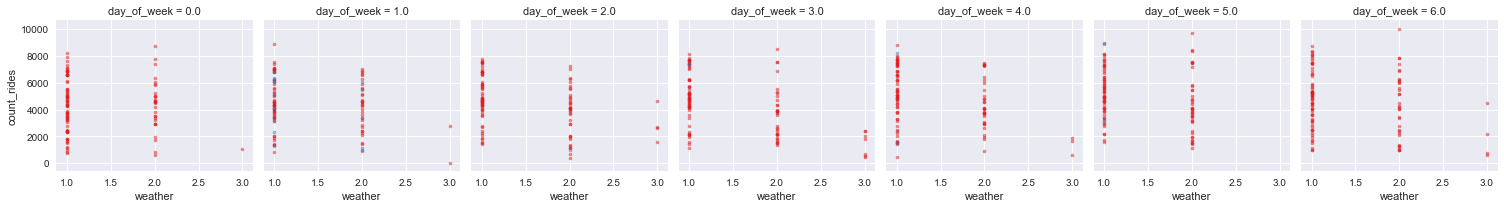

In [11]:
plot_categorical_differences(df_total,"day_of_week","weather","count_rides","holiday")

If the stated data convention (where Sunday = 0) is correct, the busiest days of the week are actually Thursday, followed by Friday, then Saturday.  Sunday is the least busy day for rentals.

2) How about bike rentals on holidays?

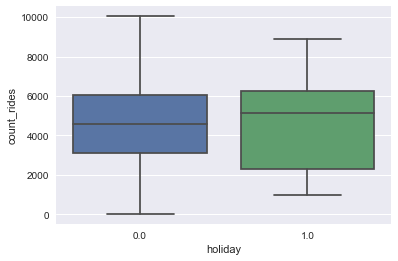

In [12]:
#bike rentals on holidays
holiday_bool = df_total['holiday']
ride_frequency = df_total['count_rides']

holiday_rental_freq = sns.boxplot(holiday_bool, ride_frequency)


** It appears there is more rides on average during holidays. However, the variance in the holiday rides frequency is higher and the distribution seems to be skewed to the right. **

3) What effect does the season have on the bike rentals on a given day?

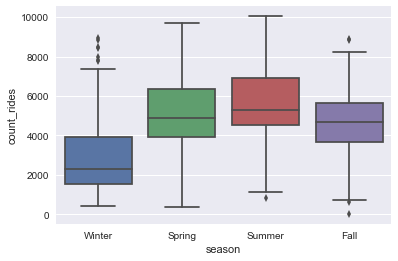

In [13]:
#Dependence of count rides based on season

#seasons_grouping=df_total.groupby('season')

seasons= sns.boxplot(x='season',y='count_rides',data=df_total)
plt.xticks([0,1,2,3],['Winter','Spring','Summer','Fall']);
#assumed the seasons were shifted in the description on the top

** More rentals happen in the summer, closely followed by spring. The least rentals happen in the winter.** 

4) How does rain or snow affect the frequency of bike rides?

,season,month,holiday,day_of_week,workingday,temp,atemp,humidity,windspeed,count_rides
weather,,,,,,,,,,
1.0,2.498920,6.462203,0.032397,2.952484,0.663067,17.254860,19.779698,56.559439,0.190253,4889.285097
2.0,2.453441,6.493927,0.024291,3.064777,0.716599,14.639676,17.538462,72.588678,0.186431,4154.506073
3.0,2.952381,8.095238,0.000000,3.190476,0.761905,12.333333,15.000000,84.887248,0.243336,1803.285714


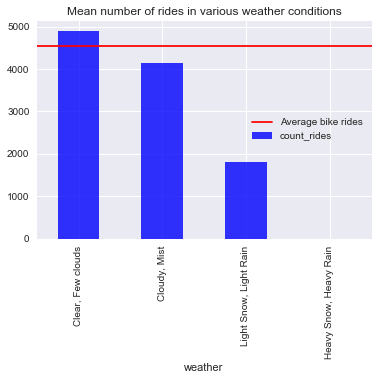

In [14]:
#Calculate the overall mean of rides
avg_bike_rentals=df_total['count_rides'].mean() 

#group the dataframe by weather conditions
rain_or_snow = df_total.groupby('weather').mean()
rain_or_snow.loc[len(rain_or_snow)+1]=[0,0,0,0,0,0,0,0,0,0] 

rain_or_snow['count_rides'].plot.bar(alpha=0.8,color='b')
plt.xticks(range(len(rain_or_snow['count_rides'])),["Clear, Few clouds", "Cloudy, Mist", "Light Snow, Light Rain", "Heavy Snow, Heavy Rain"])
plt.title("Mean number of rides in various weather conditions")

plt.axhline(y=avg_bike_rentals, xmin=0, xmax=1, hold=None, color='r',label='Average bike rides')
plt.legend()

df_total.groupby('weather').mean()

** There is significantly less rentals during rainy or snowy periods of time. No data points with weather attribute 4 were in the data set meaning that no rentals occured during heavy rain or snow.**

5) How does temperature effect bike rentals?

count    731.000000
mean      16.229822
std       11.531101
min      -11.000000
25%        6.000000
50%       16.000000
75%       26.000000
max       39.000000
Name: temp, dtype: float64

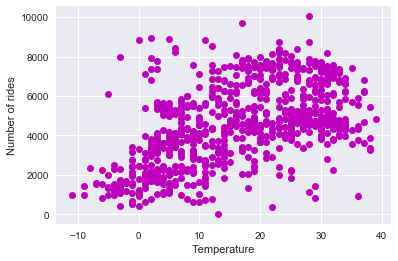

In [15]:
x_train = df_total['temp']
y_train = df_total['count_rides']

plt.plot (x_train,y_train,'mo')
plt.xlabel("Temperature")
plt.ylabel("Number of rides")

x_train.describe()

** We can see a slightly non-linear relationship between temperature and number of rides.  If it gets too hot or too cold, the number of rides will decrease.  Generally, most rides happen between 15 and 30 degrees. **

6) Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?

** There is some non-linear dependence between temperature and the number of rentals (see previous chart). The variables humidity and wind speed seem to be only loosely influencing the number of rentals. **

** The same non-linear relationship holds true for Apparent temperature: **

count    731.000000
mean      18.885089
std       10.278475
min       -6.000000
25%       10.000000
50%       20.000000
75%       27.000000
max       42.000000
Name: atemp, dtype: float64

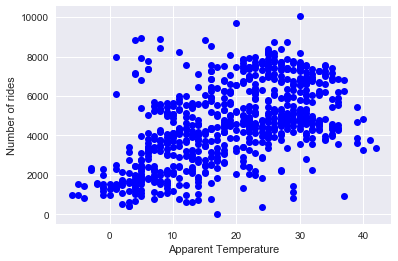

In [16]:
x_train = df_total['atemp']
y_train = df_total['count_rides']

plt.plot (x_train,y_train,'bo')
plt.xlabel("Apparent Temperature")
plt.ylabel("Number of rides")
x_train.describe()

** Effect of humidity - does not seem to be tightly correlated with number of rentals, but most rides were take between 40-80% humidity of the air. This is probably because that's a normal humidity range for Washington D.C.**

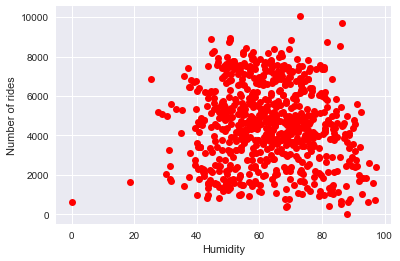

In [17]:
plt.plot (df_total['humidity'],df_total['count_rides'],'ro')
plt.xlabel("Humidity")
plt.ylabel("Number of rides")

** Effect of wind speed - does not seem to be strongly correlated with the number of rentals, although with smaller wind speeds there appears to be more slightly more rides. **

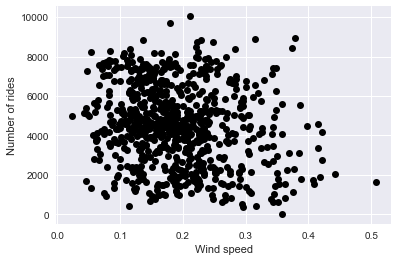

In [18]:
plt.plot (df_total['windspeed'],df_total['count_rides'],'ko')
plt.xlabel("Wind speed")
plt.ylabel("Number of rides")

your answers here

** Repeating the answers from above, in a more concise form.  See the charts above for more details:**
* 1) If the stated data convention (where Sunday = 0) is correct, the busiest days of the week are actually Thursday, followed by Friday, then Saturday.  Sunday is the least busy day for rentals.
* 2) It appears there is more rides on average during holidays. However, the variance in the holiday rides frequency is higher and the distribution seems to be skewed to the right.
* 3) More rentals happen in the summer, closely followed by spring. The least rentals happen in the winter.
* 4) There is significantly less rentals during rainy or snowy periods of time. No data points with weather attribute 4 were in the data set meaning that no rentals occured during heavy rain or snow.
* 5) We can see a slightly non-linear relationship between temperature and number of rides. If it gets too hot or too cold, the number of rides will decrease. Generally, most rides happen between 15 and 30 degrees.
* 6) There is some non-linear dependence between temperature and the number of rentals. Apparent temperature also has a non-linear relationship.  The variables humidity and wind speed seem to be only loosely influencing the number of rentals.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

Why can't categorical variables be directly used as predictors?
* ** The problem is that the higher the categorical variable, the "better" that category will seem to be for that model, however, weather = 0 (clear sky) is not "better" or worse than weather = 1 (light mist) **
* ** We need to convert to a binary system where all the categories will be presented in binary (0-false, 1-true) in each separate column to avoid this issue.**

Why is it okay to not have a binary column for the  Kj-th category?
* **If the binary representation is zero for all the Kj-th-1 categories, we know it needs to be in the last category.  Essentially, the remaining category is our intercept. **

Why shouldn't we include the test set observations in computing the mean and SD?
* **This would be cheating.  Our training mean and sd would be influenced by the data we will be testing on, which could lead to overfitting. **

In [19]:
df_train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [20]:
from sklearn import preprocessing
def clean_and_encode(df):
    encode = preprocessing.LabelEncoder()

    for column in df.columns:
        if df[column].dtype == np.object:
            df[column] = df[column].fillna('')
            df.loc[:, column] = encode.fit_transform(df[column])
        
    df = df.fillna(0)

    df.head()
    
    return df

In [21]:
#get dummies for each categorical variable

#for the training test
proc_df_train = clean_and_encode(df_train)
proc_df_train=pd.get_dummies(df_train,columns=['season','month','day_of_week','weather'])

#for the test set
proc_df_test=pd.get_dummies(df_test,columns=['season','month','day_of_week','weather'])

#get rid of the last column for each category - we know that if an observation does not fit any K-1th category, 
#it needs to be in the last one

columns_to_drop=['season_4.0','day_of_week_6.0','month_12.0']


for column in columns_to_drop:
    proc_df_train.pop(column)
    proc_df_test.pop(column)

proc_df_train.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1.0,season_2.0,season_3.0,...,month_11.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,weather_1.0,weather_2.0,weather_3.0
0,0.0,1.0,24.0,26.0,76.5833,0.118167,6073.0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,0.0,0.0,0.0,4.0,58.6250,0.169779,2431.0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.0,1.0,23.0,23.0,91.7083,0.097021,1996.0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [22]:
#Normalizing the data for continuous variables (need to create a copy to not override my data frames)
#training set
n_proc_df_train=proc_df_train.copy(deep=True)
n_proc_df_train.loc[:,"temp":"windspeed"]=(proc_df_train.loc[:,"temp":"windspeed"]-proc_df_train.loc[:,"temp":"windspeed"].mean())/proc_df_train.loc[:,"temp":"windspeed"].std()

#test set - use mean and std of the training set
n_proc_df_test=proc_df_test.copy(deep=True)
n_proc_df_test.loc[:,"temp":"windspeed"]=(proc_df_test.loc[:,"temp":"windspeed"]-proc_df_test.loc[:,"temp":"windspeed"].mean())/proc_df_test.loc[:,"temp":"windspeed"].std()

#print(proc_df_test.loc[:,"temp"].head())
#print(proc_df_train.loc[:,"temp"].mean())

In [23]:
n_proc_df_train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1.0,season_2.0,season_3.0,...,month_11.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,weather_1.0,weather_2.0,weather_3.0
count,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.033233,0.670695,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130,0.217523,0.259819,0.265861,...,0.093656,0.160121,0.175227,0.135952,0.123867,0.123867,0.145015,0.640483,0.329305,0.030211
std,0.179515,0.470672,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338,0.413186,0.439199,0.442459,...,0.291790,0.367273,0.380736,0.343256,0.329929,0.329929,0.352649,0.480585,0.470672,0.171428
min,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
n_proc_df_test.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1.0,season_2.0,season_3.0,...,month_11.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,weather_1.0,weather_2.0,weather_3.0
count,400.00000,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.00000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,0.02500,0.695000,-1.136244e-17,-2.824130e-17,2.276929e-15,1.106337e-15,4514.21250,0.272500,0.245000,0.250000,...,0.072500,0.130000,0.117500,0.147500,0.157500,0.157500,0.140000,0.627500,0.345000,0.02750
std,0.15632,0.460984,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2092.60635,0.445803,0.430626,0.433555,...,0.259639,0.336725,0.322418,0.355048,0.364728,0.364728,0.347422,0.484076,0.475964,0.16374
min,0.00000,0.000000,-2.086733e+00,-2.119826e+00,-4.397757e+00,-1.881065e+00,22.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.00000,0.000000,-8.980743e-01,-8.862659e-01,-8.133533e-01,-7.176605e-01,2875.25000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.00000,1.000000,-4.903218e-02,-3.226235e-02,-1.647755e-02,-9.165791e-02,4516.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
75%,0.00000,1.000000,8.849141e-01,9.166304e-01,7.505049e-01,5.518796e-01,6174.75000,1.000000,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
max,1.00000,1.000000,1.988669e+00,2.245080e+00,2.305789e+00,4.121656e+00,10045.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [25]:
#create y-train
y_train=proc_df_train['count']
#create x-train
X_train=proc_df_train.drop('count',axis=1)
#create y-test
y_test=proc_df_test['count']
#create x-test
X_test = proc_df_test.drop('count',axis=1)
all_features = list(X_train.columns) # Save these for part 1e) later



train_ols = sm.OLS(y_train, sm.add_constant(X_train))
ols_fit = train_ols.fit()

y_pred_train = ols_fit.predict(sm.add_constant(X_train))
train_r2 = r2_score(y_train, y_pred_train)

y_pred_test = ols_fit.predict(sm.add_constant(X_test))
test_r2 = r2_score(y_test, y_pred_test)

print("training r-squared =", train_r2,"\ntest r-squared =", test_r2)

#T-test
model_params=ols_fit.params

ttest=ols_fit.pvalues
ttest_signif=ttest[ttest.values<0.05]

#print("All parameters")
#print(model_params)
print('\n')
print("Coefficients of predictors")
print(model_params[ttest.values<0.05])
print('\n')
print("p-values of coefficients")
print(ttest_signif)

training r-squared = 0.576128178313 
test r-squared = 0.249342111465


Coefficients of predictors
const          4309.941989
humidity        -38.263065
windspeed     -3260.749571
season_1.0    -1226.186543
weather_1.0    1969.495619
weather_2.0    1952.929035
dtype: float64


p-values of coefficients
const          5.464660e-12
humidity       2.020827e-06
windspeed      1.744235e-03
season_1.0     1.612408e-02
weather_1.0    2.169716e-22
weather_2.0    4.116530e-14
dtype: float64


Which among the predictors have a positive correlation with the number of bike rentals?

** months (1,2,3,4,5 and 9,10,11),temp, atemp, day_of_week_3.0 as well asweather_1.0, weather_2.0 and weather_3.0**

Does the day of a week have a relationship with bike rentals?

** Day of the week does not have statistically significant relationship at 95% confidence level with bike rentals and the correlation is positive. Which makes sense, people do not have to work on the weekends and can go rent bikes more.**

Does the month influence the bike rentals?

** No month has a statistically significant effect on the bike rentals.**

What effect does a holiday have on bike rentals?

**Slightly positive, but not statistically significant at 95% confidence level.**

Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.

** Although both temp and atemp had their p-values above 0.05, from looking at the coeffients, we noticed temp had higher weight (82.710082) than atemp (31.460512). This may have been caused by the fact people look at their phone for temperature and do not go out and perceive the "feels like" temperature first.**

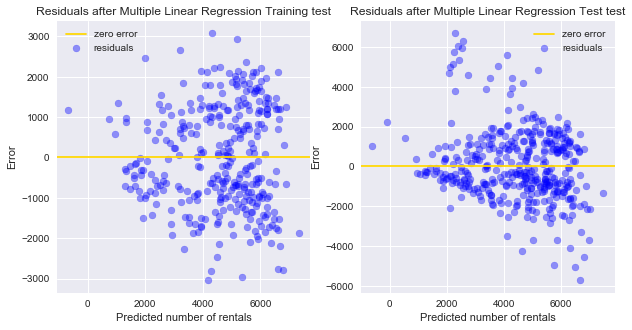

In [26]:
#fig, ax = plt.subplots(1, 1, figsize=(15, 8))

errors=y_train-ols_fit.predict(sm.add_constant(X_train))

errors_test=y_test-ols_fit.predict(sm.add_constant(X_test))
#print(y_train.shape)
#print(ols_fit.predict(sm.add_constant(X_train)).shape)
#print(errors.shape)
#print(sm.add_constant(X_train).shape)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)


plt.scatter(ols_fit.predict(sm.add_constant(X_train)), errors, color='blue', alpha=0.4, label='residuals')
                               
plt.axhline(y=0, color='gold', label='zero error')

plt.legend(loc='best');
plt.title('Residuals after Multiple Linear Regression Training test');
plt.xlabel('Predicted number of rentals');
plt.ylabel('Error');

plt.subplot(1,2,2)
plt.scatter(ols_fit.predict(sm.add_constant(X_test)), errors_test, color='blue', alpha=0.4, label='residuals')

plt.title('Residuals after Multiple Linear Regression Test test');
plt.xlabel('Predicted number of rentals');
plt.ylabel('Error');
plt.axhline(y=0, color='gold', label='zero error')
plt.legend(loc='best');

Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?

** There is a significant variance of about 2000 in the error terms in the residual plot for training set and even more so for the test set. This confirms our model (R^2) is just mediocre. There  is also some non-linearity for the higher numbers of rentals (looks like a slight negative skew in the variance).  This is likely caused by non-linearities with temperature as the summer months have the higher number of rentals. **


## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

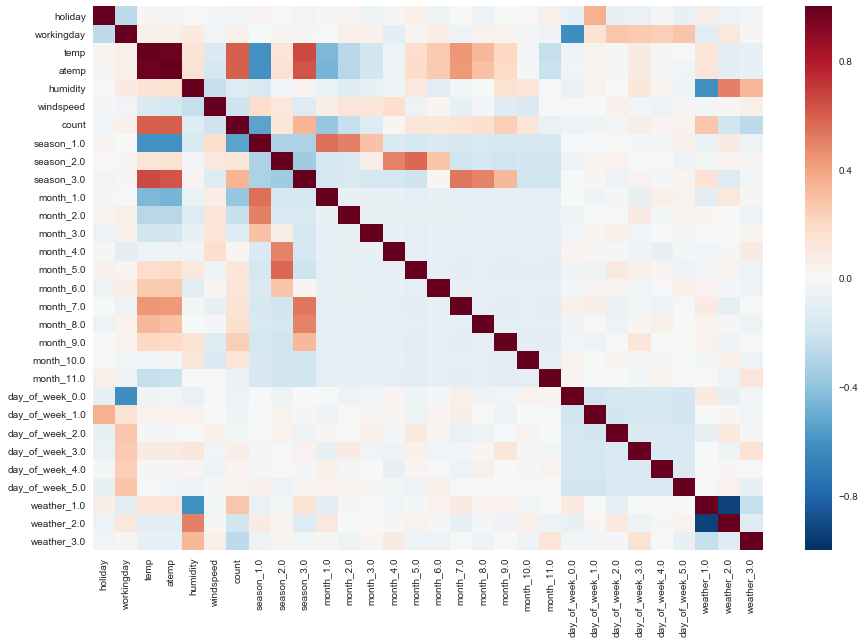

In [27]:
a=np.corrcoef(n_proc_df_train.T)
plt.figure(figsize=(15,10))
sns.heatmap(a, xticklabels=list(n_proc_df_train.columns), yticklabels=list(n_proc_df_train.columns))


Does the data suffer from multi-collinearity?  Are there predictors that fall into natural groups based on the correlation values?

* ** temp and atemp are nearly 100% correlated, and they would make a good natural group. **
* ** seasons are also correlated with the months inside the season **
* ** Workingday and day of week_0 are strongly negatively correlated (basically sunday is never a working day) **

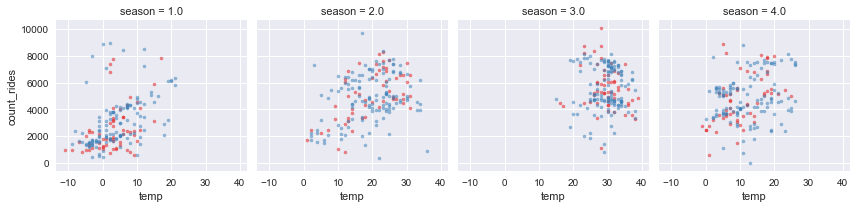

In [28]:
g = sns.FacetGrid(df_total, col="season", hue="workingday", palette="Set1")
g.map(plt.scatter, "temp", "count_rides", alpha=0.5, s=10);

#Visualisation how temperature affects number of rides taken in any given season. 
#There is not enough holidays in each season to draw conclusions.

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [ ]:
### Forward selection:

def get_bic(mrm, x, y, j):
    # BIC = n * ln(MSE) + Num_params * ln(n)
    MSE = ((y - mrm.predict(x)) ** 2).mean()
    n = len(y)
    return n * np.log(MSE) + j * np.log(n)


def get_best_feature(x_train, y_train, current_features, potential_features):
    # Returns the best feature set to add from potential_features
    mrm = LinearRegression(fit_intercept=True)
    best_bic = np.float('inf')
    
    for new_feature in potential_features:
        features = list(current_features)
        features.append(new_feature)
        
        mrm.fit(x_train[features], y_train)
        new_bic = get_bic(mrm, x_train[features], y_train, len(features))
        
        if new_bic < best_bic:
            best_bic = new_bic
            best_feature = new_feature
    
    return best_feature


# First let's make a copy of the previous dfs just in case.  Hey, it's 2017 and we all have lots of memory right?
x_train = n_proc_df_train.copy(deep = True).drop('count', axis=1)
x_validation = n_proc_df_test.copy(deep = True).drop('count', axis=1)

y_train = n_proc_df_train['count'].copy(deep = True)
y_validation = n_proc_df_test['count'].copy(deep = True)

mrm = LinearRegression(fit_intercept=True)

# Now, build M_k that minimizes BIC of training set for each additional feature
remaining_features = list(x_train.columns)
M_k = [[]]
    
for k in range(1, len(remaining_features)+1):
    this_best_feature = get_best_feature(x_train, y_train, M_k[k-1], remaining_features)
    k_features = list(M_k[k-1])
    
    k_features.append(this_best_feature)
    remaining_features.remove(this_best_feature)
    M_k.append(k_features)

# Finally, choose the M_k that minimizes training set BIC
best_bic = np.float('inf')

for this_feature_set in M_k[1:]:
    mrm.fit(x_train[this_feature_set], y_train)
    this_bic = get_bic(mrm, x_train[this_feature_set], y_train, len(this_feature_set))
    print("Length of feature set",len(this_feature_set))
    print("Training BIC =", this_bic, "Training R^2 =",mrm.score(x_train[this_feature_set], y_train), "Test R^2 =", mrm.score(x_validation[this_feature_set], y_validation))
    if this_bic < best_bic:
        best_bic = this_bic
        best_forward_features = this_feature_set

print("Best feature set found is", best_forward_features,"with training BIC of",best_bic)

mrm.fit(x_train[best_forward_features], y_train)
test_r2_forward = mrm.score(x_validation[best_forward_features], y_validation)
print("\n")
print("This set gives training R^2 of", mrm.score(x_train[best_forward_features], y_train),"and validation R^2 of",test_r2_forward)

In [29]:
### Forward selection:
def select_best_features(n_proc_df_train,n_proc_df_test):
#selects best features to use as predictors using the minimum BIC and linear regression
#input is the train and test sets

    def get_bic(mrm, x, y, j):
        # BIC = n * ln(MSE) + Num_params * ln(n)
        MSE = ((y - mrm.predict(x)) ** 2).mean()
        n = len(y)
        return n * np.log(MSE) + j * np.log(n)


    def get_best_feature(x_train, y_train, current_features, potential_features):
        # Returns the best feature set to add from potential_features
        mrm = LinearRegression(fit_intercept=True)
        best_bic = np.float('inf')

        for new_feature in potential_features:
            features = list(current_features)
            features.append(new_feature)

            mrm.fit(x_train[features], y_train)
            new_bic = get_bic(mrm, x_train[features], y_train, len(features))

            if new_bic < best_bic:
                best_bic = new_bic
                best_feature = new_feature

        return best_feature


    # First let's make a copy of the previous dfs just in case.  Hey, it's 2017 and we all have lots of memory right?
    x_train = n_proc_df_train.copy(deep = True).drop('count', axis=1)
    x_validation = n_proc_df_test.copy(deep = True).drop('count', axis=1)

    y_train = n_proc_df_train['count'].copy(deep = True)
    y_validation = n_proc_df_test['count'].copy(deep = True)

    mrm = LinearRegression(fit_intercept=True)

    # Now, build M_k that minimizes BIC of training set for each additional feature
    remaining_features = list(x_train.columns)
    M_k = [[]]

    for k in range(1, len(remaining_features)+1):
        this_best_feature = get_best_feature(x_train, y_train, M_k[k-1], remaining_features)
        k_features = list(M_k[k-1])

        k_features.append(this_best_feature)
        remaining_features.remove(this_best_feature)
        M_k.append(k_features)

    # Finally, choose the M_k that minimizes training set BIC
    best_bic = np.float('inf')

    for this_feature_set in M_k[1:]:
        mrm.fit(x_train[this_feature_set], y_train)
        this_bic = get_bic(mrm, x_train[this_feature_set], y_train, len(this_feature_set))
        print("Length of feature set",len(this_feature_set))
        print("Training BIC =", this_bic, "Training R^2 =",mrm.score(x_train[this_feature_set], y_train), "Test R^2 =", mrm.score(x_validation[this_feature_set], y_validation))
        if this_bic < best_bic:
            best_bic = this_bic
            best_forward_features = this_feature_set

    print("Best feature set found is", best_forward_features,"with training BIC of",best_bic)

    mrm.fit(x_train[best_forward_features], y_train)
    test_r2_forward = mrm.score(x_validation[best_forward_features], y_validation)
    print("\n")
    print("This set gives training R^2 of", mrm.score(x_train[best_forward_features], y_train),"and validation R^2 of",test_r2_forward)
    
    return best_forward_features

In [31]:
a = select_best_features(n_proc_df_train,n_proc_df_test)

Length of feature set 1
Training BIC = 4866.62314611 Training R^2 = 0.360948111394 Test R^2 = 0.195959273669
Length of feature set 2
Training BIC = 4844.65408629 Training R^2 = 0.412377453847 Test R^2 = 0.19758822159
Length of feature set 3
Training BIC = 4817.47924345 Training R^2 = 0.46809945209 Test R^2 = 0.233765153612
Length of feature set 4
Training BIC = 4805.79180041 Training R^2 = 0.495474704787 Test R^2 = 0.26716330024
Length of feature set 5
Training BIC = 4798.71533925 Training R^2 = 0.514727842797 Test R^2 = 0.263357793553
Length of feature set 6
Training BIC = 4793.78966009 Training R^2 = 0.530203501987 Test R^2 = 0.267346494482
Length of feature set 7
Training BIC = 4792.65937017 Training R^2 = 0.539940519637 Test R^2 = 0.276914333803
Length of feature set 8
Training BIC = 4792.36217999 Training R^2 = 0.548340366825 Test R^2 = 0.273967735775
Length of feature set 9
Training BIC = 4794.86557329 Training R^2 = 0.552819223107 Test R^2 = 0.271721691398
Length of feature set 

In [ ]:
### Reverse selection:

def get_bic(mrm, x, y, j):
    # BIC = n * ln(MSE) + Num_params * ln(n)
    MSE = ((y - mrm.predict(x)) ** 2).mean()
    n = len(y)
    return n * np.log(MSE) + j * np.log(n)


def get_best_feature_to_drop(x_train, y_train, current_features):
    # Returns the best feature set to drop from potential_features
    mrm = LinearRegression(fit_intercept=True)
    best_bic = np.float('inf')
    
    for new_feature in current_features:
        features = list(current_features)
        features.remove(new_feature)
        
        mrm.fit(x_train[features], y_train)
        new_bic = get_bic(mrm, x_train[features], y_train, len(features))
        #print(new_feature," bic:",new_bic)
        
        if new_bic < best_bic:
            best_bic = new_bic
            best_feature_to_drop = new_feature
    
    return best_feature_to_drop


# First let's make a copy of the previous dfs just in case.  Hey, it's 2017 and we all have lots of memory right?
x_train = n_proc_df_train.copy(deep = True).drop('count', axis=1)
x_validation = n_proc_df_test.copy(deep = True).drop('count', axis=1)

y_train = n_proc_df_train['count'].copy(deep = True)
y_validation = n_proc_df_test['count'].copy(deep = True)

# Now, build M_k that minimizes BIC of training set for each additional feature
remaining_features = list(x_train.columns)
M_k = [remaining_features]
    
for k in range(len(remaining_features)-1):
    remaining_features = list(M_k[0])
    remaining_features.remove(get_best_feature_to_drop(x_train, y_train, M_k[0]))
    M_k.insert(0, remaining_features)

# Finally, choose the M_k that minimizes training set BIC
best_bic = np.float('inf')

for this_feature_set in M_k:
    mrm.fit(x_train[this_feature_set], y_train)
    this_bic = get_bic(mrm, x_train[this_feature_set], y_train, len(this_feature_set))
    print("Training BIC =", this_bic, "Training R^2 =",mrm.score(x_train[this_feature_set], y_train), "Test R^2 =", mrm.score(x_validation[this_feature_set], y_validation))
    if this_bic < best_bic:
        best_bic = this_bic
        best_reverse_features = this_feature_set

print("Best feature set found is", best_reverse_features,"with training BIC of",best_bic)

mrm.fit(x_train[best_reverse_features], y_train)
test_r2_reverse = mrm.score(x_validation[best_reverse_features], y_validation)
print("This set gives training R^2 of", mrm.score(x_train[best_reverse_features], y_train),"and test R^2 of",test_r2_reverse)

Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? 

** Yes!  For example, the forward selection removes temp and the reverse selection removes atemp.  They're highly correlated so only one of the two features is sufficient in each case.  The two methods likely keep different features (between atemp vs. temp) due to the order of the features. **

** We also see reduced redundancy in the season/month pairings.  Each set has Season 1 and does NOT have month 1, 2, 3.**

In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test  R2R2  scores for the fitted models compare with the model fitted in Part (b) using all predictors?

** Our forward/reverse selection algorithms improve our test R^2: **
* ** Part (b) test R^2 = 0.249 **
* ** Forward selection test R^2 = 0.274 **
* ** Reverse selection test R^2 = 0.273 **

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [ ]:
def getKFoldsR2(x_train, y_train, x_val, y_val, features, n = 10):
# Returns a list of n R^2 values for the passed training and validation sets.  n is number of folds
    train_r2, val_r2 = [], []
    folds = KFold(n_splits = n)
    
    for train_index, val_index in folds.split(x_train):
        mrm = LinearRegression(fit_intercept=True)
        mrm.fit(x_train[features].iloc[train_index], y_train.iloc[train_index])
        train_r2.append(mrm.score(x_train[features].iloc[train_index], y_train.iloc[train_index]))
        val_r2.append(mrm.score(x_val[features].iloc[val_index], y_val.iloc[val_index])) 
    return train_r2, val_r2


x_train = n_proc_df_train.copy(deep = True).drop('count', axis=1)
y_train = n_proc_df_train['count'].copy(deep = True)

x_val = n_proc_df_train.copy(deep = True).drop('count', axis=1)
y_val = n_proc_df_train['count'].copy(deep = True)

all_train_r2, all_val_r2 = getKFoldsR2(x_train, y_train, x_val, y_val, all_features)
forward_train_r2, forward_val_r2 = getKFoldsR2(x_train, y_train, x_val, y_val, best_forward_features)
reverse_train_r2, reverse_val_r2 = getKFoldsR2(x_train, y_train, x_val, y_val, best_reverse_features)

print("All features validation R^2 =", np.array(all_val_r2).mean())
print("Forward selection validation R^2 =", np.array(forward_val_r2).mean())
print("Reverse selection validation R^2 =", np.array(reverse_val_r2).mean())

#print(all_train_r2,"\n",forward_train_r2, "\n", reverse_train_r2)
#print("\n")
#print(all_val_r2, "\n", forward_train_r2, "\n", reverse_train_r2)
print("\n")
print("From earlier calculations:")
print("All features test R^2 =", test_r2)
print("Forward selection test R^2 =", test_r2_forward)
print("Reverse selection test R^2 =", test_r2_reverse)


your answers here

Report the average  R^2  across all 10 validation sets for each model and compare the results. Why do you think this is the case?

* ** The average R^2 for the forward and reverse selection models is higher than the all features model (R^2~0.45-0.46 vs. 0.34) for the validation set.  This is logical since the all features model is more likely to exhibit multicollinearity and overfit on the training set. **
* ** Interestingly, the range of R^2 values ACROSS the 10 folds was also much higher than the range of R^2 for the optimized models.  We believe this is also an artifact of multicollinearity. **

Evaluate each of the 3 models on the provided left out test set by calculating  R2R2 . Do the results agree with the cross-validation? Why or why not?

* ** The test set performs more poorly than the validation set, but again, R^2 is maximized for the forward/reverse selection models  (0.274 vs. 0.273, respectively) vs. All test features (R^2 0.249).  Both of these outcomes are to be expected.  First, the test set will likely perform worse than the validation sets since it's out of sample.  Secondly, the test set performs better with the optimized model because it will have less multicollinearity and less overfitting. **
